In [1]:
# 기본 데이터 핸들링
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm

# 토큰화
from konlpy.tag import Komoran

# 텍스트 데이터 분석
from wordcloud import WordCloud
from nltk.tokenize import TreebankWordTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

# 시각화 한글 설정
%matplotlib inline
from matplotlib import font_manager, rc
import platform
ttf= 'c:/Windows/Fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname=ttf).get_name()
rc('font', family=font_name)

# Preprocessing
from sklearn.model_selection import train_test_split

# Modeling
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier

# Scoring
from sklearn.metrics import f1_score

In [2]:
# 데이터 불러오기
df_semi = pd.read_csv('Full_data/semiconductor_stock.csv')
df_elec = pd.read_csv('Full_data/electric_car_battery_stock.csv')
df_chem = pd.read_csv('Full_data/petrochemistry_stock.csv')
df_ship = pd.read_csv('Full_data/shipbuilding_shiping_stock.csv')
df_steel = pd.read_csv('Full_data/steel_stock.csv')

df_all = pd.concat([df_semi, df_elec, df_chem, df_ship, df_steel])

# Preprocessing

In [3]:
# 본문 내용 전처리기
def content_preprocessor(text):
    text = re.sub('[\(\[\{].*?[\)\]\}]', '', text) # Remove text in special symbol
    text = re.sub('(?<=\d)\.(?=\d)', 'TMP', text) # Convert Period to TMP
    text = re.sub('[^a-zA-Z0-9가-힣%]', ' ', text) # if no korean, english, number -> remove
    text = re.sub('TMP', '.', text) # Convert TMP to Period
    text = re.sub('\s+', ' ', text) # Remove to many space
    
    return text

# 제목 전처리기
def title_preprocessor(text):
    #text = re.sub('[\(\[\{].*?[\)\]\}]', '', text) # Remove text in special symbol
    text = re.sub('(?<=\d)\.(?=\d)', 'TMP', text) # Convert Period to TMP
    text = re.sub('[^a-zA-Z0-9가-힣%]', ' ', text) # if no korean, english, number -> remove
    text = re.sub('TMP', '.', text) # Convert TMP to Period
    text = re.sub('\s+', ' ', text) # Remove to many space
    
    return text

# 텍스트 데이터 토큰화
def text_tokenizer(text):
    try:
        return komoran.pos(text)
    except:
        return pd.NA

# 단어 사전 생성기
def dict_creater(pair_text, df_word_dict, stopwords): # 기존에 str 형태로 저장되어 있던 것을 list 형태로 변환
    for pt in pair_text:
        if pt[1] not in unuse_tag and pt[0] not in stopwords: # 기존 사전에 존재하는 단어는 +1을, 없던 단어는 1로 생성
            try:
                df_word_dict[pt[0]] += 1
            except:
                df_word_dict[pt[0]] = 1

In [4]:
tqdm.pandas() # tqdm을 통해서 pandas에서 진행과정을 보여주는 코드
komoran = Komoran()

# 인터넷에서 수집한 stopword 파일
base_stopwords = list(pd.read_csv('stopword.txt', header=None)[0])

# 추가로 수집한 기업과 특수한 단어들을 불용어로 처리
add_stop = ['삼성전자','SK하이닉스','현대차','LG에너지솔루션','LG화학','SK이노베이션','롯데케미칼','S-OIL','HD현대중공업',
            '대우조선해양','현대미포조선', '삼성중공업', 'HD한국조선해양', 'HMM', '팬오션', '현대제철', 'POSCO홀딩스', '고려아연',
            '쓰','이','에','엔','솔','있','조선','한화','위하']

stopwords = base_stopwords + add_stop

# komoran의 태그에서 사용하지 않을 태그 리스트 생성
unuse_tag = ['JKS','JKC','JKG','JKO','JKB','JKV','JKQ','JX','JC','EP','EF','EC','ETN','ETM',
             'XPN','XSN','XSV','XSA','XR','SF','SP','SS','SE','SO','SH','SW','NF','NV','SN','NA']


dict_lst = {}
for idx, df in enumerate([df_semi, df_elec, df_chem, df_ship, df_steel]):
    df_title_dict = {} # 빈 딕셔너리 생성
    df_content_dict = {} # 빈 딕셔너리 생성
    name = ['반도체','전기차_2차전지','석유화학','조선해운','철강']
    
    df['preprocessed_title'] = df['Title'].apply(title_preprocessor) # 전처리기 
    df['preprocessed_content'] = df['Content'].apply(content_preprocessor) # 전처리기
    
    df['title_token'] = df['preprocessed_title'].progress_apply(text_tokenizer) # 토큰화
    df['content_token'] = df['preprocessed_content'].progress_apply(text_tokenizer) # 토큰화
    
    df = df.dropna(subset=['title_token','content_token']) # 해당열의 결측값 제거
    
    df['title_token'].progress_apply(lambda x : dict_creater(x, df_title_dict, stopwords)) # 단어사전 생성기
    df['content_token'].progress_apply(lambda x : dict_creater(x, df_content_dict, stopwords)) # 단어사전 생성기
    dict_lst[name[idx]] = [df_title_dict, df_content_dict] # 두 딕셔너리를 리스트로 묶어서 섹터별로 딕셔너리에 추가

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6654/6654 [00:11<00:00, 599.32it/s]


# WordCloud

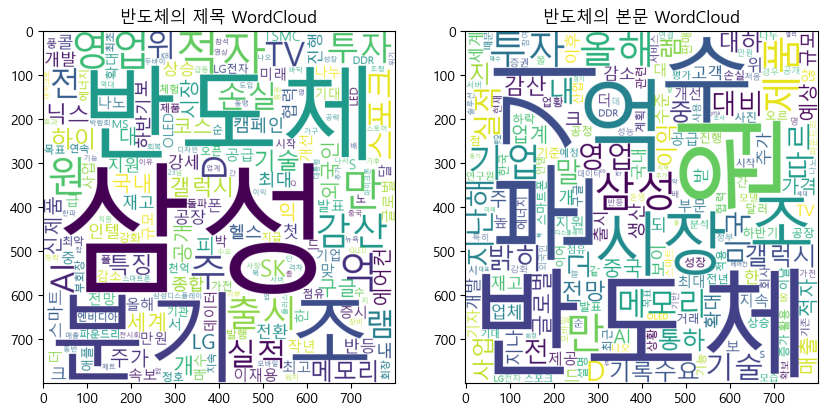

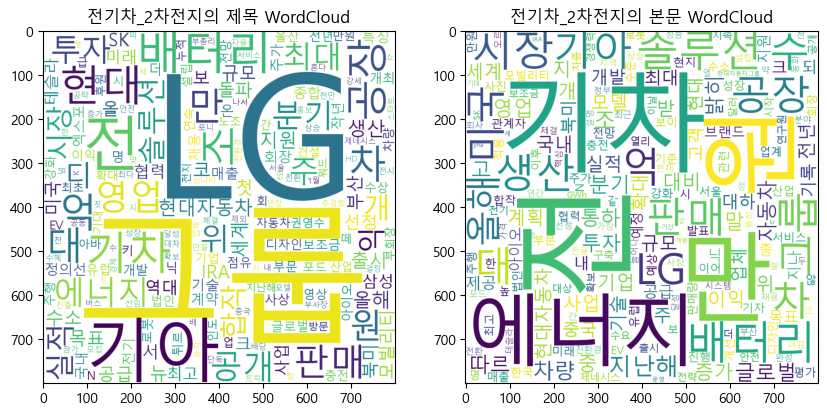

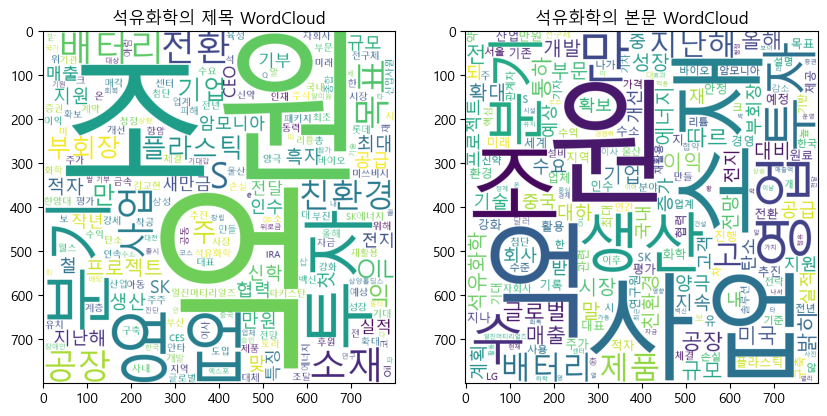

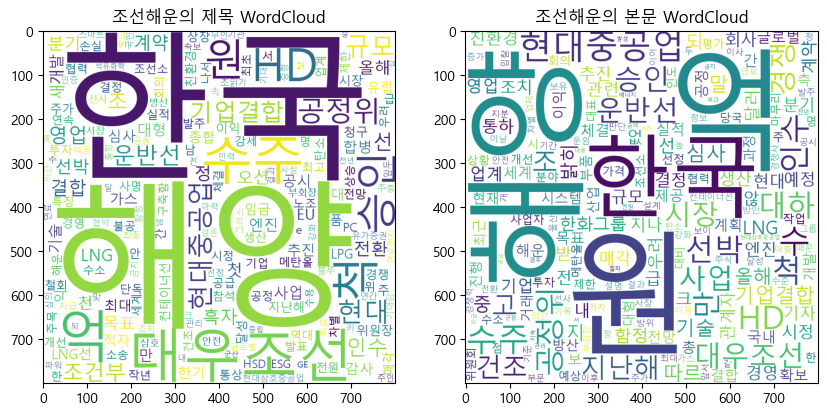

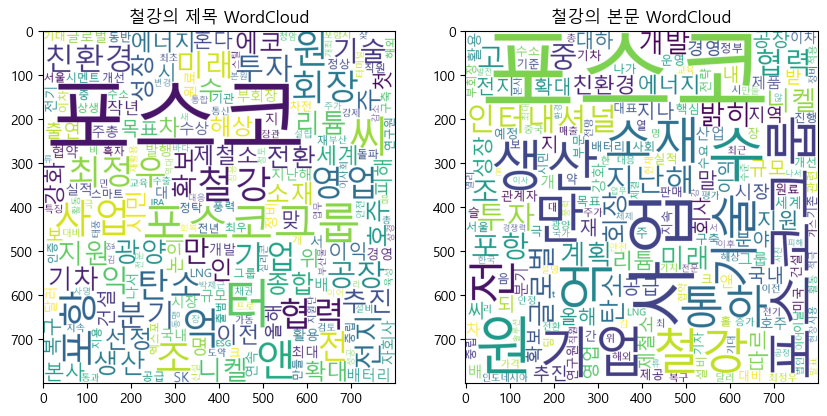

In [8]:
# 폰트 경로 설정
font_path = 'C:\\Users\\Lee_HJ\\anaconda3\\envs\\text\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\malgun.ttf'

# 워드 클라우드 선언
cloud = WordCloud(font_path = font_path,background_color='white',width=800, height=800)

# 시각화
for key, value in dict_lst.items():
    # 제목과 기사의 워드 클라우드 생성
    title_cloud = cloud.generate_from_frequencies(value[0]).to_array()
    content_cloud = cloud.generate_from_frequencies(value[1]).to_array()
    
    fig = plt.figure(figsize=(10, 10))
    plt.subplot(1,2,1)
    plt.imshow(title_cloud)
    plt.savefig(f'word_cloud/{key}_title_wordcloud.png')
    plt.title(f'{key}의 제목 WordCloud')
    
    plt.subplot(1,2,2)
    plt.imshow(content_cloud)
    plt.savefig(f'word_cloud/{key}_content_wordcloud.png')
    plt.title(f'{key}의 본문 WordCloud')
    plt.show()

# Text Classification

In [5]:
sector_dict = {'반도체' : ['삼성전자','SK하이닉스'], '전기차_2차전지' : ['현대차','LG에너지솔루션'],
             '석유화학' : ['LG화학','SK이노베이션','롯데케미칼','S-OIL'],
             '조선해운' : ['HD현대중공업','대우조선해양','삼성중공업','HD한국조선해양'],
             '철강' : ['HMM','팬오션','현대제철','POSCO홀딩스','고려아연']}

# 분류를 위한 라벨 생성
df_all['label'] = df_all.Stock_Item.apply(lambda x : 1 if x in sector_dict['반도체'] else 
                                          (2 if x in sector_dict['전기차_2차전지'] else
                                           (3 if x in sector_dict['석유화학'] else
                                            (4 if x in sector_dict['조선해운'] else 5))))
df_all['preprocessed_title'] = df_all['Title'].apply(title_preprocessor) # 전처리
df_all['preprocessed_content'] = df_all['Content'].apply(content_preprocessor) # 전처리

In [8]:
# tf-idf 생성
tfidf = TfidfVectorizer(stop_words=stopwords)
tfidf_mat_title = tfidf.fit_transform(df_all['preprocessed_title'])
tfidf_mat_content = tfidf.fit_transform(df_all['preprocessed_content'])

tt_X = tfidf_mat_title.toarray()
clf_label = df_all['label'].to_numpy()
reg_label = df_all['Diff'].to_numpy()

C:\Users\Lee_HJ\anaconda3\envs\textdata\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['hd한국조선해양', 'hd현대중공업', 'hmm', 'lg에너지솔루션', 'lg화학', 'oil', 'posco홀딩스', 'sk이노베이션', 'sk하이닉스', '가서', '같은', '것과', '결과에', '결론을', '관계가', '관련이', '그런', '그럼에도', '그렇게', '그에', '그치지', '김에', '까닭에', '낫다', '년도', '논하지', '누가', '다시', '달려', '대로', '대해', '되는', '되다', '되어', '들면', '들자면', '듯하다', '따르는', '따름이다', '따지지', '때가', '만은', '만이', '만큼', '많은', '말하면', '말할것도', '몰라도', '몰랏다', '못하다', '미치다', '바꾸어서', '바꿔', '밖에', '방면으로', '보면', '보아', '부류의', '비길수', '비추어', '뿐만', '사람들', '상대적으로', '생각이다', '서술한바와같이', '쓰여', '아니다', '아니라', '안다', '안된다', '않고', '않기', '않는다면', '않다', '않다면', '않도록', '않으면', '알겠는가', '어쩔수', '어찌됏든', '없고', '없다', '예를', '외에', '요만한', '우에', '위에서', '이렇게', '이로', '이르다', '이와', '이유는', '인하여', '임에', '점에서', '정도에', '정도의', '종합한것과같이', '주저하지', '줄은', '지경이다', '틀림없다', '편이', '하고', '하기', '하기만', '하는', '하는것만', '하는것이', '하다', '하면', '하지

In [18]:
# 훈련 데이터와 학습 데이터 분리
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(tt_X, clf_label, 
                                                                    test_size=0.25, stratify=clf_label)
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(tt_X, reg_label, 
                                                                    test_size=0.25)

In [19]:
# Text Classification by title
model = LGBMClassifier()
model.fit(X_clf_train, y_clf_train)
y_pred = model.predict(X_clf_test)
f1_score(y_clf_test, y_pred, average='micro')

0.9425299006689641

# Price Predict

In [20]:
# Predict Diff
model = LGBMRegressor()
model.fit(X_reg_train, y_reg_train)
y_pred = model.predict(X_reg_test)
mean_squared_error(y_reg_test, y_pred)

20515752.98383823